In [3]:
import tensorflow as tf
import os

_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=_URL, extract=True)

base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')


68606236/68606236 [==============================] - 0s 0us/step


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np

# Image Data Generators
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 32
img_size = (160, 160)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

# Load MobileNetV2 model + higher layers
base_model = MobileNetV2(input_shape=(160, 160, 3), include_top=False, weights='imagenet')

# Extract features
def extract_features(generator, sample_count):
    features = np.zeros(shape=(sample_count, 5, 5, 1280))  # dimensions depend on the base model
    labels = np.zeros(shape=(sample_count))

    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = base_model.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break

    return features, labels

train_features, train_labels = extract_features(train_generator, 2000)  # Use appropriate sample count
validation_features, validation_labels = extract_features(validation_generator, 1000)

train_features = np.reshape(train_features, (2000, 5 * 5 * 1280))
validation_features = np.reshape(validation_features, (1000, 5 * 5 * 1280))


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 130ms/step


In [5]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create an SVM classifier
svm_model = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='linear', C=1.0))
])

svm_model.fit(train_features, train_labels)


Pipeline(steps=[('scaler', StandardScaler()), ('svm', SVC(kernel='linear'))])

Validation accuracy: 0.98


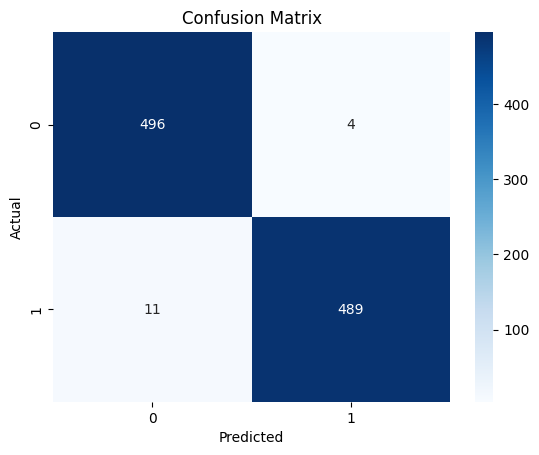

              precision    recall  f1-score   support

        Cats       0.98      0.99      0.99       500
        Dogs       0.99      0.98      0.98       500

    accuracy                           0.98      1000
   macro avg       0.99      0.98      0.98      1000
weighted avg       0.99      0.98      0.98      1000

1/1 [==============================] - 1s 832ms/step


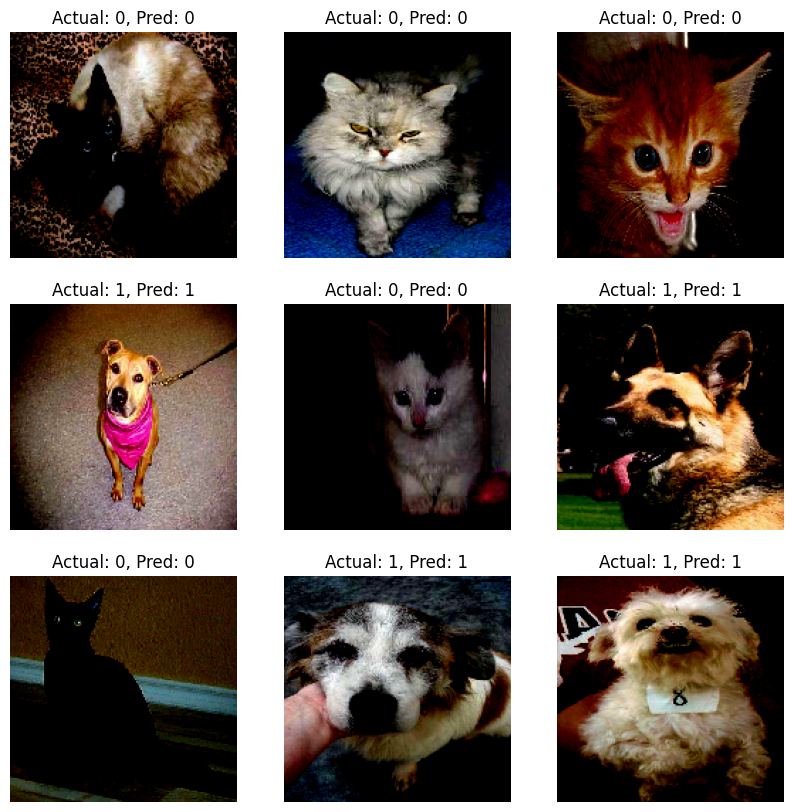

In [6]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on validation set
validation_predictions = svm_model.predict(validation_features)
accuracy = accuracy_score(validation_labels, validation_predictions)
print(f'Validation accuracy: {accuracy:.2f}')

# Confusion Matrix
cm = confusion_matrix(validation_labels, validation_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(validation_labels, validation_predictions, target_names=['Cats', 'Dogs'])
print(report)

# Visualize some predictions
def plot_images(images, labels, preds):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f'Actual: {labels[i]}, Pred: {preds[i]}')
        plt.axis('off')
    plt.show()

# Get some validation images and their labels
validation_images, validation_labels_orig = next(validation_generator)

# Extract features for these images
validation_features = base_model.predict(validation_images)
validation_features = np.reshape(validation_features, (validation_images.shape[0], 5 * 5 * 1280))

# Predict using the SVM model
validation_preds = svm_model.predict(validation_features)

# Plot images with actual and predicted labels
plot_images(validation_images, validation_labels_orig.astype(int), validation_preds.astype(int))
